# Irfan Rahmanindra - G2504917A
# IN6227-2023-Assignment-1
## Data Preprocessing
### 1. Data Loading
#### 1.1 Load Census Data (adult.data and adult.test) with column

In [1]:
import pandas as pd
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

#### ii. Data read in PandaFrame with appropriate data column

In [2]:
train = pd.read_csv('../data/raw/adult.data', names=columns, na_values='?', skipinitialspace=True)
test = pd.read_csv('../data/raw/adult.test', names=columns, na_values='?', skipinitialspace=True, skiprows=1)

### Checking Total Empty data

In [3]:
train.isnull().sum()
test.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

### 2. Handle Missing Value 
#### i.	Missing value converts from “?” to NaN to mark missing entries (when read data)
#### ii.Remove empty value in rows to ensure clean dataset

In [4]:
train = train.dropna()
test = train.dropna()

### Rechecking Total Empty data

In [5]:
train.isnull().sum()
test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## 3. Data Cleaning

#### i.	“fnlwgt” removed, cause irrelevant to income

In [6]:
train = train.drop('fnlwgt', axis=1)

#### ii.	Remove extra dots from the labels in the test data to match training dataset format

In [7]:
train['income'] = train['income'].str.replace('.', '', regex=False)

###	Separate column into text and number type. To ensure every feature type has appropriate process

In [8]:
categorical = train.select_dtypes(include=['object']).columns.drop('income')
numerical = train.select_dtypes(include=['int64', 'float64']).columns

###	Create Pipeline to process column. Use one-hot encoding to turn text columns into numbers.
### Adjust number column to same scale. To help model learn better and faster

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

### Save cleaned data so it can be reuse

In [10]:
train.to_csv('../data/processed/adult_train_clean.csv', index=False)
test.to_csv('../data/processed/adult_test_clean.csv', index=False)

## Model Setup
### a. Choosing Classification: Logistic Regression and Random Forest
### b. Hyperparameter Tuning
#### For Logisitic Regression -> max_iter = 1000 (Ensure Convergence)
#### For Random Forest -> n_estimator = 100 (Balance Performance and Compute Cost)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

categorical = train.select_dtypes(include=['object']).columns.drop('income')
numerical = train.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

### Train the Models

In [12]:
pipe_lr.fit(train.drop('income', axis=1), train['income'])
pipe_rf.fit(train.drop('income', axis=1), train['income'])

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Make Predictions and Evaluate

In [13]:
pred_lr = pipe_lr.predict(test.drop('income', axis=1))
pred_rf = pipe_rf.predict(test.drop('income', axis=1))

print('Logistic Regression Results:')
print(classification_report(test['income'], pred_lr))

print('Random Forest Results:')
print(classification_report(test['income'], pred_rf))

Logistic Regression Results:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     22654
        >50K       0.74      0.61      0.67      7508

    accuracy                           0.85     30162
   macro avg       0.81      0.77      0.78     30162
weighted avg       0.84      0.85      0.84     30162

Random Forest Results:
              precision    recall  f1-score   support

       <=50K       0.98      0.99      0.98     22654
        >50K       0.96      0.94      0.95      7508

    accuracy                           0.98     30162
   macro avg       0.97      0.96      0.97     30162
weighted avg       0.97      0.98      0.97     30162



In [14]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Logistic Regression
start_train = time.time()
pipe_lr.fit(train.drop('income', axis=1), train['income'])
end_train = time.time()
lr_train_time = end_train - start_train

start_pred = time.time()
pred_lr = pipe_lr.predict(test.drop('income', axis=1))
end_pred = time.time()
lr_pred_time = end_pred - start_pred

# Random Forest
start_train = time.time()
pipe_rf.fit(train.drop('income', axis=1), train['income'])
end_train = time.time()
rf_train_time = end_train - start_train

start_pred = time.time()
pred_rf = pipe_rf.predict(test.drop('income', axis=1))
end_pred = time.time()
rf_pred_time = end_pred - start_pred

# Evaluation metrics
print('Logistic Regression Results:')
print(classification_report(test['income'], pred_lr))
print('Training time:', lr_train_time, 'seconds')
print('Prediction time:', lr_pred_time, 'seconds')

print('Random Forest Results:')
print(classification_report(test['income'], pred_rf))
print('Training time:', rf_train_time, 'seconds')
print('Prediction time:', rf_pred_time, 'seconds')

# Optional: ROC-AUC (if binary classification)
if len(set(test['income'])) == 2:
    lr_roc_auc = roc_auc_score(test['income'], pipe_lr.predict_proba(test.drop('income', axis=1))[:,1])
    rf_roc_auc = roc_auc_score(test['income'], pipe_rf.predict_proba(test.drop('income', axis=1))[:,1])
    print('Logistic Regression ROC-AUC:', lr_roc_auc)
    print('Random Forest ROC-AUC:', rf_roc_auc)



Logistic Regression Results:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     22654
        >50K       0.74      0.61      0.67      7508

    accuracy                           0.85     30162
   macro avg       0.81      0.77      0.78     30162
weighted avg       0.84      0.85      0.84     30162

Training time: 0.08895707130432129 seconds
Prediction time: 0.020812034606933594 seconds
Random Forest Results:
              precision    recall  f1-score   support

       <=50K       0.98      0.99      0.98     22654
        >50K       0.96      0.94      0.95      7508

    accuracy                           0.98     30162
   macro avg       0.97      0.96      0.97     30162
weighted avg       0.97      0.98      0.97     30162

Training time: 6.3644139766693115 seconds
Prediction time: 0.26604175567626953 seconds
Logistic Regression ROC-AUC: 0.9066367258932515
Random Forest ROC-AUC: 0.9969031914352714


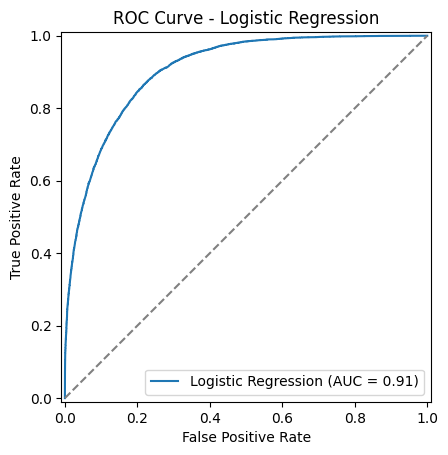

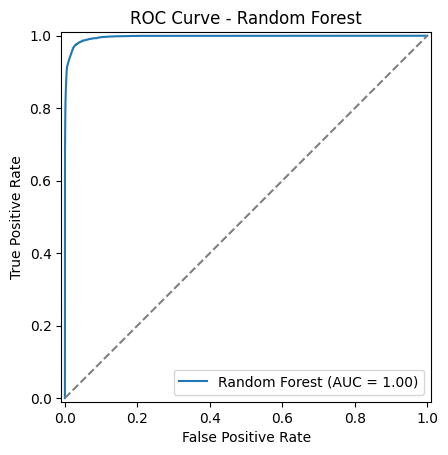

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Assuming pipe_lr is your trained pipeline and test is your test DataFrame
RocCurveDisplay.from_estimator(
    pipe_lr,  # your trained pipeline
    test.drop('income', axis=1),  # test features
    test['income'],               # test labels
    name="Logistic Regression"
)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

RocCurveDisplay.from_estimator(
    pipe_rf,
    test.drop('income', axis=1),
    test['income'],
    name="Random Forest"
)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


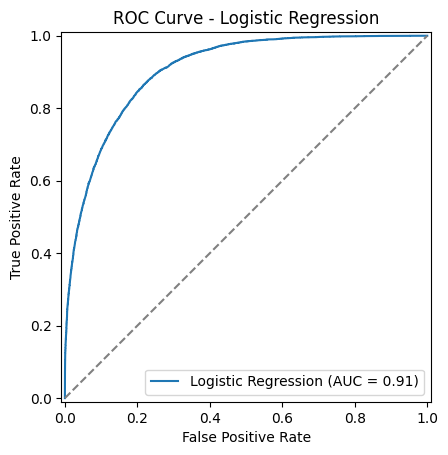

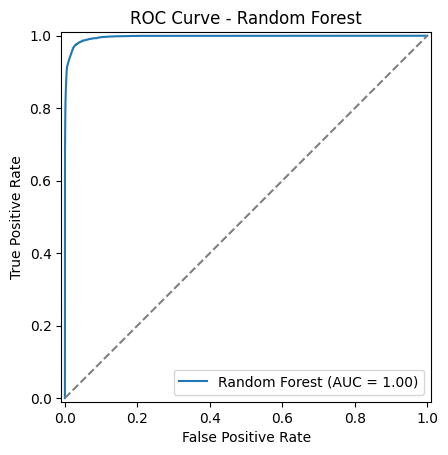

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(
    pipe_lr, 
    train.drop('income', axis=1),  
    train['income'],               
    name="Logistic Regression"
)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

RocCurveDisplay.from_estimator(
    pipe_rf,
    train.drop('income', axis=1),
    train['income'],
    name="Random Forest"
)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()
